In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pickle
import cv2
import os

Using TensorFlow backend.


In [2]:
# Definitions
default_image_size = tuple((256, 256))
data_dir = '../input/plantvillage'

height = 256
width = 256
depth = 3

lr = 1e-3
num_epochs = 25
batch_size = 32

# Helper function

Converts images to arrays

In [3]:
def imageToArray(image_file):
    image = cv2.imread(image_file)
    
    if image is not None:
        image = cv2.resize(image, default_image_size)
        return img_to_array(image)
    else:
        return None

# Loading images from dataset

In [4]:
images_list, labels_list = [], []
root_dir = os.listdir(data_dir)

# Remove .DS_Store
def removeDSStore(file, root):
    if file == '.DS_Store':
        root.remove(directory)
        
print("LOADING IMAGES ...")
for directory in root_dir:
    removeDSStore(directory, root_dir)
    
for plant_dir in root_dir:
    plants_disease_dirlist = os.listdir(f"{data_dir}/{plant_dir}")
    
    for disease_folder in plants_disease_dirlist:
        removeDSStore(disease_folder, plants_disease_dirlist)
    
    for plant_disease_folder in plants_disease_dirlist:
        print(f"PROCESSING: {plant_disease_folder} ...")
        plants_disease_imglist = os.listdir(f"{data_dir}/{plant_dir}/{plant_disease_folder}/")
        
        for single_plant_disease_image in plants_disease_imglist:
            removeDSStore(single_plant_disease_image, plants_disease_imglist)
        
        for image in plants_disease_imglist[:200]:
            image_dir = f"{data_dir}/{plant_dir}/{plant_disease_folder}/{image}"
            
            if image_dir.endswith(".jpg") == True or image_dir.endswith(".JPG") == True:
                images_list.append(imageToArray(image_dir))
                labels_list.append(plant_disease_folder)
            
print("[INFO] Image Loading finished")

LOADING IMAGES ...
PROCESSING: Tomato_Bacterial_spot ...
PROCESSING: Pepper__bell___Bacterial_spot ...
PROCESSING: Tomato_Early_blight ...
PROCESSING: Tomato__Tomato_YellowLeaf__Curl_Virus ...
PROCESSING: Potato___Early_blight ...
PROCESSING: Tomato__Target_Spot ...
PROCESSING: Pepper__bell___healthy ...
PROCESSING: Tomato_Spider_mites_Two_spotted_spider_mite ...
PROCESSING: Tomato_Late_blight ...
PROCESSING: Tomato_Leaf_Mold ...
PROCESSING: Tomato_Septoria_leaf_spot ...
PROCESSING: Potato___healthy ...
PROCESSING: Potato___Late_blight ...
PROCESSING: Tomato__Tomato_mosaic_virus ...
PROCESSING: Tomato_healthy ...
[INFO] Image Loading finished


# Converting labels

converte each image label to binary levels

In [5]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(labels_list)
pickle.dump(label_binarizer, open('label_transform.pk1', 'wb'))
n_classes = len(label_binarizer.classes_)

In [6]:
# Visualize classes

print(label_binarizer.classes_)

['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


# Preprocessing data

In [7]:
np_image_list = np.array(images_list, dtype=np.float16) / 225.0

Splitting the data into training and test.

80% of the images are used for training and 20% for testing.

In [8]:
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size = 0.2, random_state = 42)

Data augmentation

In [9]:
resized_data = ImageDataGenerator(
                rotation_range = 25,
                width_shift_range = 0.1,
                height_shift_range = 0.1,
                shear_range = 0.2,
                zoom_range = 0.2,
                horizontal_flip = True,
                fill_mode = "nearest"
)

In [10]:
# Model
model = Sequential()
inputShape = (height, width, depth)
dim = -1

if K.image_data_format() == "channel_first":
    inputShape = (depth, height, width)
    dim = 1

# Model implementation
# Input Layer
model.add(Conv2D(32, (3, 3), padding='same', input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=dim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

# Hidden Layers
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=dim))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=dim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

#Output Layer
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=dim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [11]:
optim = Adam(lr=lr, decay=lr / num_epochs)
model.compile(loss="binary_crossentropy", optimizer=optim, metrics=["accuracy"])

def train(model_tr):
    print("STARTING Training ...")
    
    history = model_tr.fit_generator(
        resized_data.flow(x_train, y_train, batch_size=batch_size),
        validation_data = (x_test, y_test),
        steps_per_epoch = len(x_train) // batch_size,
        epochs = num_epochs, verbose=1)
    
    print("FINISHING Training...")
    return history
    

In [12]:
model_tr = train(model)

STARTING Training ...
Instructions for updating:
Use tf.cast instead.
Epoch 1/25
73/73 [==============================] - 34s 471ms/step - loss: 0.2094 - acc: 0.9341 - val_loss: 0.5437 - val_acc: 0.8946
Epoch 2/25
73/73 [==============================] - 29s 398ms/step - loss: 0.1398 - acc: 0.9509 - val_loss: 0.6545 - val_acc: 0.9033
Epoch 3/25
73/73 [==============================] - 29s 394ms/step - loss: 0.1239 - acc: 0.9549 - val_loss: 0.6952 - val_acc: 0.9051
Epoch 4/25
73/73 [==============================] - 29s 400ms/step - loss: 0.1023 - acc: 0.9625 - val_loss: 0.2731 - val_acc: 0.9345
Epoch 5/25
73/73 [==============================] - 29s 395ms/step - loss: 0.1004 - acc: 0.9629 - val_loss: 0.3078 - val_acc: 0.9250
Epoch 6/25
73/73 [==============================] - 29s 396ms/step - loss: 0.0927 - acc: 0.9649 - val_loss: 0.5083 - val_acc: 0.9110
Epoch 7/25
73/73 [==============================] - 29s 399ms/step - loss: 0.0978 - acc: 0.9644 - val_loss: 0.4083 - val_acc: 0.9223

# Model evaluation

Let's plot our data to evaluate the model performance

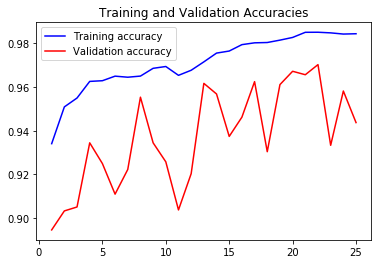

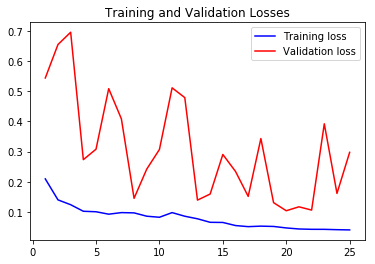

In [13]:
acc = model_tr.history['acc']
val_acc = model_tr.history['val_acc']
loss = model_tr.history['loss']
val_loss = model_tr.history['val_loss']
epochs = range(1, len(acc) + 1)

# Train and validation acc
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.figure()

# Train and validation losses
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

Calculate the accuracy of the model using x_test and y_test.

In [14]:
scores = model.evaluate(x_test, y_test)
print(f"Test accuracy: {scores[1] * 100}")

591/591 [==============================] - 1s 2ms/step
Test accuracy: 94.37112280761731


Finally, saves the model

In [15]:
print('Saving model ...')
pickle.dump(model, open('conv_model.pk1', 'wb'))

Saving model ...


In [16]:
os.listdir('./')

['__output__.json',
 'label_transform.pk1',
 '__notebook__.ipynb',
 'conv_model.pk1']